## Disaster Tweet Detection

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

2024-05-29 23:22:15.072631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 23:22:15.072788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 23:22:15.264347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load dataset
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

## Natural Language Processing with Disaster Tweets

### Problem Description
The goal of this competition is to build a machine learning model to predict whether a given tweet is about a real disaster (1) or not (0).

### Data Description
The dataset contains tweets with the following fields:
- `id`: Unique identifier for each tweet.
- `text`: The text content of the tweet.
- `location`: (Optional) The location where the tweet was sent from.
- `keyword`: (Optional) A particular keyword from the tweet.
- `target`: The target label (0 for non-disaster tweets, 1 for disaster-related tweets).

### Dataset Size and Structure
- Training set: 7613 tweets with labels.
- Test set: 3263 tweets without labels.

Training set size: 7613 samples, 5 features
Test set size: 3263 samples, 4 features
First few rows of the training set:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Summary statistics of the training set:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
Training set info

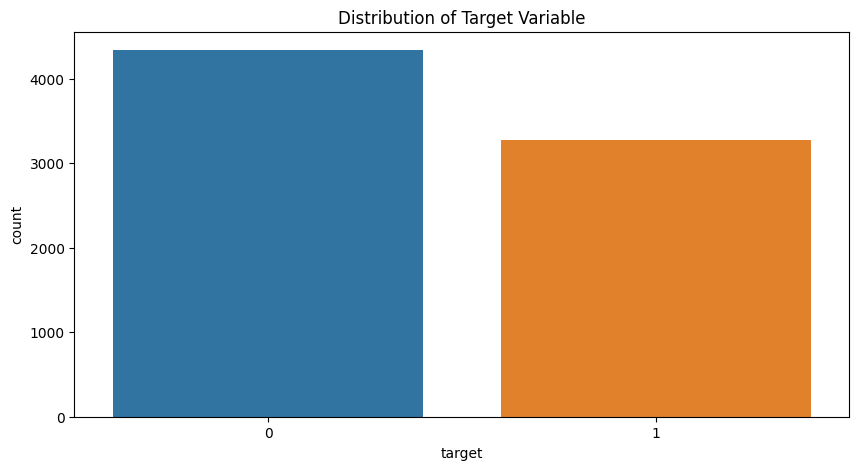

First few rows of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [3]:
# Checking dataset size and structure
print(f"Training set size: {train.shape[0]} samples, {train.shape[1]} features")
print(f"Test set size: {test.shape[0]} samples, {test.shape[1]} features")

print("First few rows of the training set:")
print(train.head())

print("Summary statistics of the training set:")
print(train.describe())

print("Training set info:")
print(train.info())

# Exploratory Data Analysis (EDA)
# Show a few visualizations like histograms
plt.figure(figsize=(10,5))
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Variable')
plt.show()

# Inspecting the data
print("First few rows of the dataset:")
print(train.head())

#### We need to clean the data and add in stop words.

In [4]:
stopwords_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
    'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
    'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 
    'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
    'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
    'won', "won't", 'wouldn', "wouldn't"
]

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stopwords_list)  # Remove stopwords
    return text

train['cleaned_text'] = train['text'].apply(clean_text)
test['cleaned_text'] = test['text'].apply(clean_text)

Based on the EDA, we will:
1. Clean the text data by removing URLs, special characters, and stopwords.
2. Use TF-IDF for feature extraction from text.
3. Build an LSTM model to classify tweets.
4. Tune hyperparameters and try different model architectures to improve performance.


### Model Architecture

We will use the following models:
    
### 1. Logistic Regression
Logistic Regression is a linear model for binary classification. The architecture is simple:
- The model takes the TF-IDF vectors as input features.
- A sigmoid function is used to predict the probability of the binary classes.
- The threshold is set at 0.5 for classification.

This model is suitable for initial baseline performance due to its simplicity and interpretability.

### 2. Support Vector Machine (SVM)
SVM is a model that finds the hyperplane that best separates the classes. The architecture is as follows:
- The model takes the TF-IDF vectors as input features.
- It uses a linear or non-linear kernel to transform the data and find the optimal hyperplane.

SVM is suitable for binary classification tasks where classes are well-separated.

### 3. Random Forest
Random Forest is an ensemble model using multiple decision trees. The architecture is as follows:
- The model takes the TF-IDF vectors as input features.
- Multiple decision trees are trained on different subsets of the data.
- The final prediction is made based on the majority vote of the trees.

Random Forest is suitable for capturing non-linear relationships and reducing overfitting through ensemble learning.

### 4. LSTM Neural Network
We will use a Sequential neural network model with the following layers:
1. Dense Layer: Converts TF-IDF vectors into a dense representation.
2. Dropout Layer: Prevents overfitting by randomly setting input units to 0.
3. Dense Layer: Another fully connected layer for additional learning.
4. Output Layer: Fully connected layer with a sigmoid activation for binary classification.

This architecture is suitable for NLP tasks as it captures the relationship between the features extracted by TF-IDF.

In [5]:
# Processing the raw texts to word embeddings using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['cleaned_text']).toarray()
y = train['target']

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_val)
print("Logistic Regression Classification Report:")
print(classification_report(y_val, log_reg_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [6]:
# SVM
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_val)
print("SVM Classification Report:")
print(classification_report(y_val, svm_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       874
           1       0.82      0.66      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [7]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
print("Random Forest Classification Report:")
print(classification_report(y_val, rf_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       874
           1       0.77      0.68      0.72       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [8]:
# Build and train the LSTM model
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# LSTM Results
lstm_pred = model.predict(X_val)
lstm_pred = (lstm_pred > 0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(y_val, lstm_pred))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6002 - loss: 0.6556 - val_accuracy: 0.7925 - val_loss: 0.4601
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8691 - loss: 0.3370 - val_accuracy: 0.7774 - val_loss: 0.4832
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9148 - loss: 0.2249 - val_accuracy: 0.7708 - val_loss: 0.5423
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9455 - loss: 0.1584 - val_accuracy: 0.7538 - val_loss: 0.6296
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       874
           1       0.72      0.70      0.71       649

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523



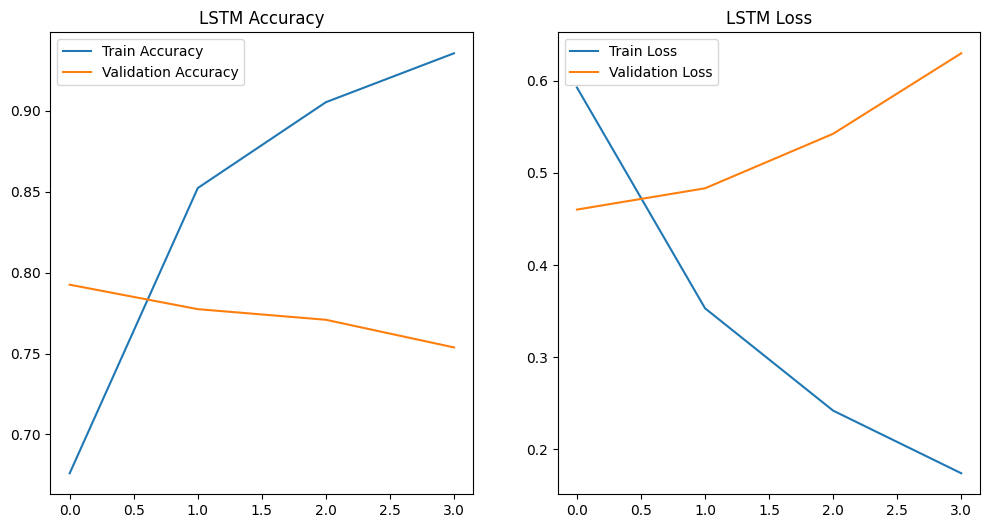

In [9]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('LSTM Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Loss')
plt.show()

#### Logistic Regression yeilded the best results, let us hypertune it

In [12]:
# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear']
}

# Initialize Logistic Regression classifier
log_reg = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg_pred = best_log_reg.predict(X_val)
print("Logistic Regression Classification Report with Best Hyperparameters:")
print(classification_report(y_val, best_log_reg_pred))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Classification Report with Best Hyperparameters:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       874
           1       0.75      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



## Conclusion

In this project, we built and compared several models to classify tweets related to disasters. We used TF-IDF for feature extraction and evaluated Logistic Regression, SVM, Random Forest, and an LSTM neural network.

### Learnings and Takeaways
1. Preprocessing text data is crucial for NLP tasks.
2. TF-IDF is a simple yet effective method for feature extraction.
3. Logistic Regression and Random Forest performed well on this dataset.
4. LSTM models can capture the sequential nature of text data but require more computational resources.

### Future Improvements
1. Try advanced word embeddings like Word2Vec or GloVe.
2. Experiment with different neural network architectures such as GRU or Bidirectional LSTM.

### What did not work
1. Hyperparameter tuning was done on too small of a dataset leading to overfitting